# DATA 1030 Project –– Part 3: Feature Engineering

### Introduction
This notebook explores feature engineering on the automated theorem proving dataset. The original dataset has 51 features (after removing two features which provided no information), and since there are a known number of features with extremely strong correlations to each other, I thought it would be helpful in speeding up runtimes to pare down the number of features I include in my model.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [21]:
df = pd.read_csv('../data/raw_data_plus_labeled_targets.csv')

features = pd.read_csv('../data/features_plus_descriptions.csv')
features.set_index('Feature Type and Number', inplace=True)
features.drop(['S5', 'D21'], axis=0, inplace=True)

X = df.loc[:,features.index]
y = df['Best Heuristic']

In [22]:
features_dict = dict.fromkeys(features.index, 'std_feat')
mm_feat = ['S1','S3', 'S4', 'S6', 'S8','S11', 'S12', 'D3', 'D39']

for feat in mm_feat:
    features_dict[feat] = 'minmax_feat'
    
minmax_feats = []
std_feats = []

for feat in features_dict.keys():
    if features_dict[feat] == 'std_feat':
        std_feats.append(feat)
    elif features_dict[feat] == 'minmax_feat':
        minmax_feats.append(feat)

print('MinMax Scaler Features: ', minmax_feats)
print('Standard Scaler Features: ', std_feats)

preprocessor = ColumnTransformer(
    transformers=[
        ('mm_scaler', MinMaxScaler(), minmax_feats),
        ('std_scaler', StandardScaler(), std_feats)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

MinMax Scaler Features:  ['S1', 'S3', 'S4', 'S6', 'S8', 'S11', 'S12', 'D3', 'D39']
Standard Scaler Features:  ['S2', 'S7', 'S9', 'S10', 'S13', 'S14', 'D1', 'D2', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32', 'D33', 'D34', 'D35', 'D36', 'D37', 'D38']


### Methods
First, I decided to plot a correlation heatmap of the features. We see that there are several features that have quite strong correlations.

In [67]:
corr_calc = []
corr_feats = []
C = X.corr()
for i,r in enumerate(C.index):
    for j,c in enumerate(C.columns):
        if i < j and np.abs(C.loc[r,c]) >= 0.8:
            corr_calc.append((r, c, np.round(C.loc[r,c], decimals=2)))
            #print(r, c, np.round(C.loc[r,c], decimals=2))
            corr_feats.append(c)
            corr_feats.append(r)

corr_calc.sort(key = lambda x: np.abs(x[2]))
for i in range(len(corr_calc)):
    print(corr_calc[i])

    
corr_feats = list(set(corr_feats))

('S4', 'S6', 0.82)
('D11', 'D12', 0.82)
('D13', 'D14', 0.82)
('S1', 'S8', -0.84)
('S3', 'D34', 0.84)
('D10', 'D12', 0.85)
('D35', 'D39', -0.85)
('S10', 'S14', 0.86)
('D26', 'D27', 0.86)
('D32', 'D36', 0.86)
('D32', 'D39', -0.86)
('D1', 'D18', -0.87)
('D18', 'D19', -0.87)
('D26', 'D29', 0.87)
('D15', 'D16', 0.88)
('D25', 'D26', 0.88)
('D35', 'D36', 0.88)
('D32', 'D37', 0.89)
('D4', 'D25', 0.9)
('D35', 'D37', 0.9)
('D4', 'D29', 0.91)
('S6', 'S8', -0.92)
('S1', 'S4', 0.94)
('D4', 'D27', 0.94)
('D37', 'D39', -0.95)
('D25', 'D27', 0.98)
('D27', 'D29', 0.98)
('D32', 'D35', 0.99)
('D1', 'D19', 1.0)
('D20', 'D31', 1.0)
('D25', 'D29', 1.0)


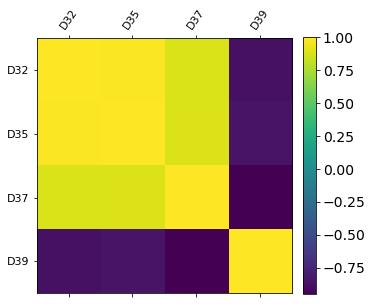

D32 Fraction of unit clauses in U
D35 Fraction of demodulator clauses in U
D37 Fraction of clauses with only positive literals in U
D39 Fraction of clauses with positive and negative literals in U


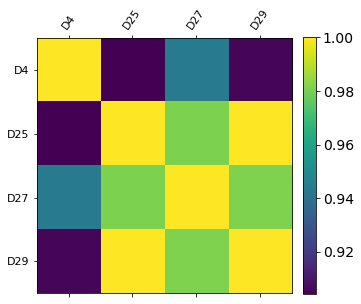

D4 |U|/|A|
D25 Ratio of the number of generated clauses to |P|
D27 Ratio of the number of generated non-trivial clauses to |P|
D29 Ratio of paramodulations to |P|


In [79]:
corr_groups = [['D32', 'D35', 'D37', 'D39'], ['D4', 'D25', 'D27', 'D29']]

for group in corr_groups:
    corr_cols = X[group]
    plt.rcParams["figure.figsize"] = [5,5]
    plt.matshow(corr_cols.corr())
    plt.xticks(range(corr_cols.shape[1]), corr_cols.columns, fontsize=11, rotation=55)
    plt.yticks(range(corr_cols.shape[1]), corr_cols.columns, fontsize=11)
    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    plt.show()
    corr_cols.corr()
    for feat in group:
        print(feat, features['Description'].loc[feat])

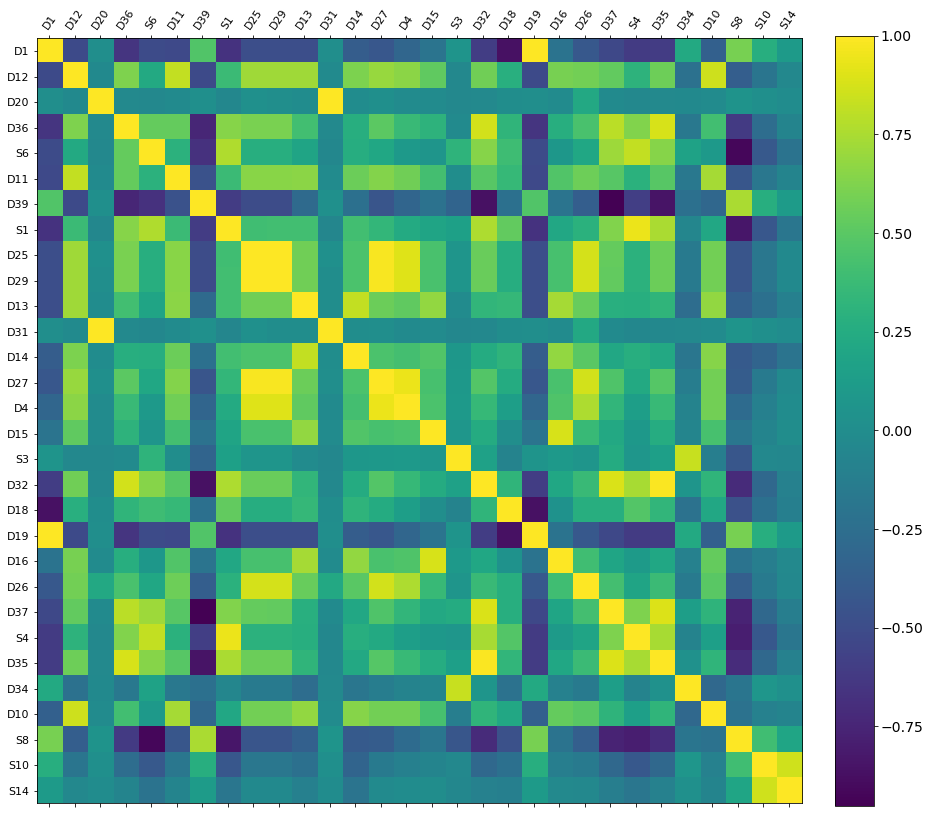

In [74]:
    
corr_cols = X[corr_feats]
corr_cols
plt.rcParams["figure.figsize"] = [15,  15]
plt.matshow(corr_cols.corr())
plt.xticks(range(corr_cols.shape[1]), corr_cols.columns, fontsize=11, rotation=55)
plt.yticks(range(corr_cols.shape[1]), corr_cols.columns, fontsize=11)
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=14)
plt.show()

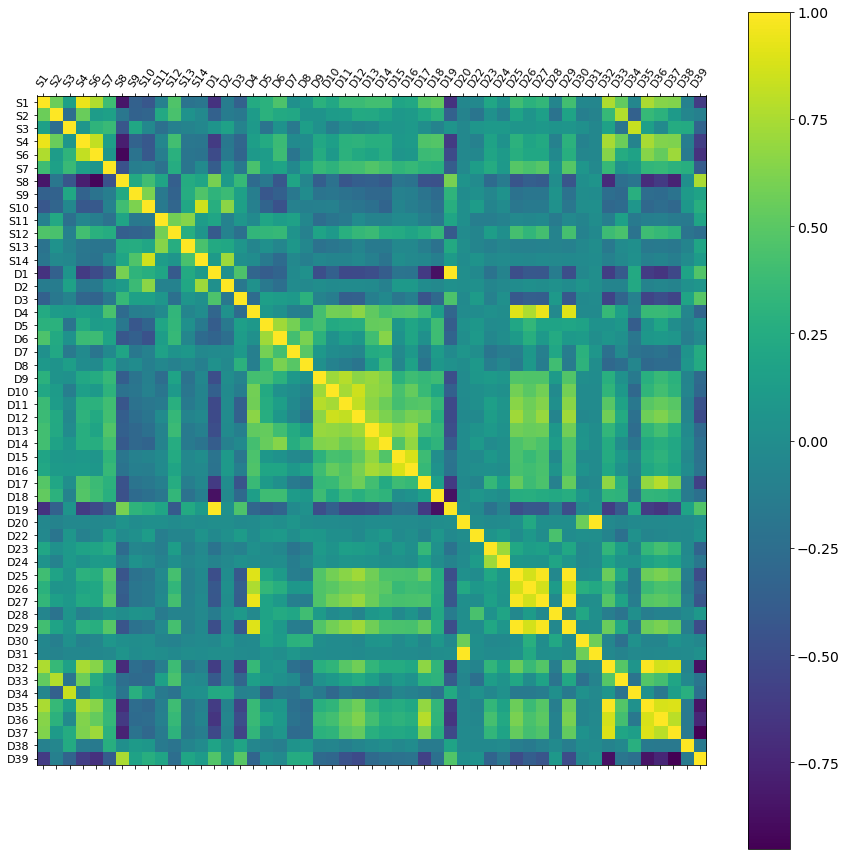

In [25]:
plt.rcParams["figure.figsize"] = [15,  15]
plt.matshow(X.corr(), )
plt.xticks(range(X.shape[1]), X.columns, fontsize=11, rotation=55)
plt.yticks(range(X.shape[1]), X.columns, fontsize=11)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [23]:
def select_K_best(score_func):
    clf = make_pipeline(preprocessor)
    best_features = []
    random_state = 431
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
    kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
    for train_index, val_index in kf.split(X_other,y_other):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_train_prep = clf.fit_transform(X_train)
        SKBest = SelectKBest(score_func=score_func, k=28)
        SKBest.fit(X_train_prep, y_train)
        best_features.append(SKBest.get_support())
    return best_features

In [18]:
def print_k_diff(bf):
    i = 0
    for a, b, c, d in zip(bf[0], bf[1], bf[2], bf[3]):
        if [a, b, c, d] == [True, True, True, True] or [a, b, c, d] == [False, False, False, False]:
            i += 1
            continue
        else: 
            print(i, a, b, c, d, '       ', features['Description'].iloc[i])
            i += 1

### Mutual Information

In [19]:
best = select_K_best(mutual_info_classif)
print_k_diff(best)

44 True False False False         Fraction of Horn clauses in U
45 False False True True         Fraction of ground clauses in U
46 False True True True         Fraction of demodulator clauses in U
47 True True False False         Fraction of rewrite rule clauses in |U|


### ANOVA F-Values

In [ ]:
best_f = f_classif_select_K_best()
print_k_diff(best_f)